# Description

Compute and analyze model performance stats.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
from typing import Any, Callable, List

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import core.statistics.requires_statsmodels as cstresta
import core.statistics.sharpe_ratio as cstshrat
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.crypto_chassis.data.client as iccdc

/app/dataflow/core/dag.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-14b68de8-a164-4348-af3b-9d7cbabd422d.json'


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  # Git
    branch_name='CMTask2294_Unify_ImClient_examples_for_CCXT_and_CryptoChassis'
    hash='68b0d0925'
    # Last commits:
      *   68b0d0925 Nina Lee Merge branch 'master' into CMTask2294_Unify_ImClient_examples_for_CCXT_and_CryptoChassis (21 minutes ago) Thu Jul 7 13:05:40 2022  (HEAD -> CMTask2294_Unify_ImClient_examples_for_CCXT_and_CryptoChassis, origin/CMTask2294_Unify_ImClient_examples_for_CCXT_and_CryptoChassis)
      |\  
      | * a61aa42eb DanilYachmenev Cmtask2266: add 1 month period for test (#2296)                   (31 minutes ago) Thu Jul 7 12:55:51 2022  (origin/master, origin/HEAD)
      * | 099daa6ca Nina Lee updated calls                                                     (37 minutes ago) Thu Jul 7 12:49:29 2022           
# Machine info
    system=Linux
    node name=a800a26c72d5
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    cpu count=8
    cpu freq=scpufreq(current

# Configs

In [4]:
def get_notebook_config() -> cconconf.Config:
    """
    Get notebook specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "im_client_params": {
            "universe_version": "v2",
            "resample_1min": True,
            "dataset": "ohlcv",
            "contract_type": "spot",
            "data_snapshot": "20220530",
        },
        "data": {
            "dir_name": "/shared_data/model/historical/experiment.E1a.crypto_chassis_v2-all.5T.2018_2022/tiled_results/",
            "columns": "volume vwap vwap.ret_0 vwap.ret_0.vol_adj vwap.ret_0.vol_adj.c vwap.ret_0.vol_adj.shift_-2 vwap.ret_0.vol_adj.shift_-2_hat".split(),
            "start_date": datetime.date(2018, 1, 1),
            "end_date": datetime.date(2022, 5, 1),
        },
        "column_names": {
            "asset_id": "asset_id",
            "timestamp": "end_ts",
            "volume": "volume",
            "y": "vwap.ret_0.vol_adj.shift_-2",
            "y_hat": "vwap.ret_0.vol_adj.shift_-2_hat",
            "hit": "hit",
            "trade_pnl": "trade_pnl",
        },
        "stats_kwargs": {
            "quantile_ranks": 10,
            # 28500 is the number of 5-minute intervals in ATH in a year.
            "time_scaling": 28500,
            "n_resamples": 1000,
            "alpha": 0.05,
        },
        "plot_kwargs": {
            "y_min_lim_hit_rate": 49,
            "y_max_lim_hit_rate": 54,
            "color": "C0",
            "capsize": 0.2,
            "xticks_rotation": 70,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [5]:
config = get_notebook_config()
print(config)

im_client_params:
  universe_version: v2
  resample_1min: True
  dataset: ohlcv
  contract_type: spot
  data_snapshot: 20220530
data:
  dir_name: /shared_data/model/historical/experiment.E1a.crypto_chassis_v2-all.5T.2018_2022/tiled_results/
  columns: ['volume', 'vwap', 'vwap.ret_0', 'vwap.ret_0.vol_adj', 'vwap.ret_0.vol_adj.c', 'vwap.ret_0.vol_adj.shift_-2', 'vwap.ret_0.vol_adj.shift_-2_hat']
  start_date: 2018-01-01
  end_date: 2022-05-01
column_names:
  asset_id: asset_id
  timestamp: end_ts
  volume: volume
  y: vwap.ret_0.vol_adj.shift_-2
  y_hat: vwap.ret_0.vol_adj.shift_-2_hat
  hit: hit
  trade_pnl: trade_pnl
stats_kwargs:
  quantile_ranks: 10
  time_scaling: 28500
  n_resamples: 1000
  alpha: 0.05
plot_kwargs:
  y_min_lim_hit_rate: 49
  y_max_lim_hit_rate: 54
  color: C0
  capsize: 0.2
  xticks_rotation: 70


# Functions

In [6]:
def load_predictions_df(config: cconconf.Config) -> pd.DataFrame:
    """
    Get data with ML predictions.
    """
    backtest_df_iter = dtfmod.yield_processed_parquet_tiles_by_year(
        config["data"]["dir_name"],
        config["data"]["start_date"],
        config["data"]["end_date"],
        config["column_names"]["asset_id"],
        data_cols=config["data"]["columns"],
        asset_ids=None,
    )
    #
    #
    predict_df = pd.concat(backtest_df_iter)
    predict_df = predict_df.sort_index()
    return predict_df


# TODO(Max): Move the code out of the lib so we can unit test,
# e.g., we want to add (small) specific unit tests for hit.
# TODO(Max): Harmonize the code with calculate_hit_rate and other code there.
# E.g., factor out the piece of calculate_hit_rate that computes hit, etc.
def preprocess_predictions_df(
    config: cconconf.Config, predict_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Preprocess data with ML predictions for analysis.

    Input:

    ```
                        volume                  vwap
    asset_id            1464553467  1467591036  1464553467  1467591036
    end_ts
    2018-01-01 09:35:00   314.0657     47.3976    729.7789  12887.3945
    2018-01-01 09:40:00   178.6543     35.1098    731.0134  12913.6854
    ```

    Output:

    ```
                                              volume        vwap
    end_ts                        asset_id
    2018-01-01 09:35:00  binance::ETH_USDT  314.0657    729.7789
                         binance::BTC_USDT   47.3976  12887.3945
    2018-01-01 09:40:00  binance::ETH_USDT  178.6543    731.0134
                         binance::BTC_USDT   35.1098  12913.6854
    ```
    """
    # Convert the prediction stats data to Multiindex by time and asset id.
    metrics_df = predict_df.stack()
    # Drop NaNs to compute the performance statistics.
    metrics_df = hpandas.dropna(metrics_df, report_stats=True)
    # Compute hit.
    metrics_df["hit"] = (
        metrics_df[config["column_names"]["y"]]
        * metrics_df[config["column_names"]["y_hat"]]
        >= 0
    )
    # Convert hit rates to desired format (`calculate_hit_rate` input).
    metrics_df["hit"] = metrics_df["hit"].replace(True, 1)
    metrics_df["hit"] = metrics_df["hit"].replace(False, -1)
    # Compute trade PnL.
    metrics_df["trade_pnl"] = (
        metrics_df[config["column_names"]["y"]]
        * metrics_df[config["column_names"]["y_hat"]]
    )
    # TODO(*): Think about avoiding using `ImClient` for mapping.
    # Convert asset ids to full symbols using `ImClient` mapping.
    im_client = iccdc.get_CryptoChassisHistoricalPqByTileClient_example1(
        **config["im_client_params"]
    )
    metrics_df.index = metrics_df.index.set_levels(
        metrics_df.index.levels[1].map(
            im_client._asset_id_to_full_symbol_mapping
        ),
        level=1,
    )
    return metrics_df


# TODO(*): Consider using bootstraping function from SciPy
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html.
# TODO(Dan): Consider to return CI values.
def bootstrap(
    data: pd.Series, func: Callable, n_resamples: int = 100
) -> List[Any]:
    """
    Bootstrap computations on specified number of data resamples.

    :param data: input data to resample
    :param func: function accepting a series and returning a single scalar value
    :param n_resamples: number of resamples to create
    :return: bootstrapped computations
    """
    res_list = []
    for i in range(n_resamples):
        resampled_data = data.sample(frac=1, replace=True)
        res = func(resampled_data)
        res_list.append(res)
    return res_list


def compute_sharpe_ratio(
    config: cconconf.Config, metrics_df: pd.DataFrame, by_col: str
) -> None:
    """
    Compute Sharpe Ratio by specified column.
    """
    res_list = []
    for by, data in metrics_df.groupby(by_col):
        srs = data[config["column_names"]["trade_pnl"]].dropna()
        func = lambda pnl: cstshrat.compute_sharpe_ratio(
            pnl, time_scaling=config["stats_kwargs"]["time_scaling"]
        )
        # Multiple Sharpe Ratios are being computed on many resamples
        # in order to find and plot confidence intervals.
        sharpe_ratio_srs = pd.Series(
            bootstrap(srs, func, config["stats_kwargs"]["n_resamples"]),
            name="sharpe_ratio",
        )
        # Transform and combine data for plotting.
        sharpe_ratio_df = sharpe_ratio_srs.to_frame()
        sharpe_ratio_df[by_col] = by
        res_list.append(sharpe_ratio_df)
    res_df = pd.concat(res_list)
    #
    return res_df


def calculate_hit_rate_with_CI(
    df: pd.DataFrame, group_by: str, value_col: str
) -> pd.DataFrame:
    """
    Compute hit rates, confidence intervals and errors relative to the specific
    entity.

    :param df: data with hit rates values
    :param group_by: column name for grouping entity
    :param value_col: column name for PnL data
    :return: data with CIs and errors
    """
    # Calculate mean value of statistics as well as CIs for each entity.
    hit_df_stacked = df.groupby([group_by])[value_col].apply(
        lambda data: cstresta.calculate_hit_rate(
            data, alpha=config["stats_kwargs"]["alpha"]
        )
    )
    # Process the output and add errors.
    hit_df = hit_df_stacked.unstack()
    hit_errors_df = add_errors_to_ci_data(hit_df)
    return hit_errors_df


def calculate_CI_for_PnLs_or_SR(
    df: pd.DataFrame, group_by: str, value_col: str
) -> pd.DataFrame:
    """
    Compute mean PnL or Sharpe Ratio, confidence intervals and errors relative
    to the specific entity.

    :param df: data with PnL or Sharpe Ratio values
    :param group_by: column name for grouping entity
    :param value_col: column name for PnL or Sharpe Ratio data
    :return: data with CIs and errors
    """
    grouper = df.groupby([group_by])[value_col]
    # Calculate mean value of statistics for each entity.
    pnl_df = grouper.mean().to_frame()
    # Compute confidence intervals.
    conf_ints = grouper.apply(
        lambda data: st.t.interval(
            1 - config["stats_kwargs"]["alpha"],
            data.size - 1,
            np.mean(data),
            st.sem(data),
        )
    )
    # Attach confidence intervals to the mean value data.
    pnl_df[["low", "high"]] = pd.DataFrame(conf_ints.tolist(), index=pnl_df.index)
    # Unify columns and calculate errors (required values for plotting).
    pnl_errors_df = add_errors_to_ci_data(pnl_df)
    return pnl_errors_df


def add_errors_to_ci_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process CI data and add errors.
    """
    # Unify columns for all plotting data.
    df.columns = ["y", "ci_low", "ci_high"]
    # Required values for plotting (`yerr` input).
    df["errors"] = (df["ci_high"] - df["ci_low"]) / 2
    return df


def plot_stats_barplot(
    df: pd.DataFrame,
    sort_by: str,
    ascending: bool,
    ylabel: str,
    ylim_min: str,
    ylim_max: str,
) -> None:
    """
    :param df: data with prediction statistics
    :param sort_by: sorting parameter (e.g., by value, by asset, or None)
    :param ylabel: name of the Y-axis graph
    :param ylim_min: lower value on Y-axis graph scale
    :param ylim_max: upper value on Y-axis graph scale
    :return: barplot with model performance statistics
    """
    # Sort data according to the input params.
    if sort_by == "x":
        df_sorted = df.sort_index(ascending=ascending)
    elif not sort_by:
        df_sorted = df.copy()
    else:
        df_sorted = df.sort_values(by=sort_by, ascending=ascending)
    # Specify errors for plotting.
    errors = df_sorted["errors"]
    # Plotting params.
    df_sorted["y"].plot.bar(
        yerr=errors,
        capsize=4,
        width=0.8,
    )
    plt.xticks(rotation=xticks_rotation)
    plt.ylabel(ylabel)
    plt.ylim(ylim_min, ylim_max)
    plt.show()


def plot_bars_with_widget(
    df: pd.DataFrame,
    ylabel: str,
    ylim_min: float,
    ylim_max: float,
) -> None:
    """
    Add widgets to expand the sorting parameters for barplots.

    :param df: data with prediction statistics
    :param ylabel: name of the Y-axis graph
    :param ylim_min: lower value on Y-axis graph scale
    :param ylim_max: upper value on Y-axis graph scale
    :return: barplot with edible model performance statistics
    """
    _ = widgets.interact(
        plot_stats_barplot,
        df=widgets.fixed(df),
        sort_by=widgets.ToggleButtons(
            options=["x", "y", "ci_low", "ci_high", False], description="Sort by:"
        ),
        ascending=widgets.ToggleButtons(
            options=[True, False], description="Ascending:"
        ),
        ylabel=widgets.fixed(ylabel),
        ylim_min=widgets.FloatText(
            value=ylim_min,
            description="Min y-value:",
        ),
        ylim_max=widgets.FloatText(
            value=ylim_max,
            description="Max y-value:",
        ),
    )

# Load data with predictions

In [7]:
predict_df = load_predictions_df(config)
print(predict_df.shape)
predict_df.head(3)

  0%|          | 0/5 [00:00<?, ?it/s]

(123119, 224)


volume                              vwap                          vwap.ret_0                       vwap.ret_0.vol_adj                       vwap.ret_0.vol_adj.c                       vwap.ret_0.vol_adj.shift_-2                       vwap.ret_0.vol_adj.shift_-2_hat                           volume                                                                                                                                                                                                                                                                                                                           vwap                                                                                                                                                                                                                                                                                                                     vwap.ret_0                                              \
asset_id                  1464553467 1467591036 2061507978  1464553467    1467591036 2061507978 1464553467 1467591036 2061507978         1464553467 1467591036 2061507978           1464553467 1467591036 2061507978           1464553467 1467591036 2061507978               1464553467 1467591036 2061507978 1032127330 1269521755 1345967712 1480530030 1579162287 1606590437 2002879833 2050321118 2061357471 2063960810 2152163375 2237530510 2425180446 2502756391 2568064341 2743007870 2870803583 2871263732 3065029174 3145747555 3187272957 3254199816 3303714233 3554906657 6132418113 6352701412 6514937930 7348328528 8968126878 1032127330 1269521755 1345967712 1480530030 1579162287 1606590437 2002879833 2050321118 2061357471 2063960810 2152163375 2237530510 2425180446 2502756391 2568064341 2743007870 2870803583 2871263732 3065029174 3145747555 3187272957 3254199816 3303714233 3554906657 6132418113 6352701412 6514937930 7348328528 8968126878 1032127330 1269521755 1345967712 1480530030 1579162287   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2018-01-01 09:35:00-05:00  314.06346  47.446994        NaN  729.777396  12887.299954        NaN        NaN        NaN        NaN                NaN        NaN        NaN                  NaN        NaN        NaN                  NaN        NaN        NaN                      NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN   
2018-01-01 09:40:00-

# Compute overall PnL

<AxesSubplot:xlabel='end_ts'>

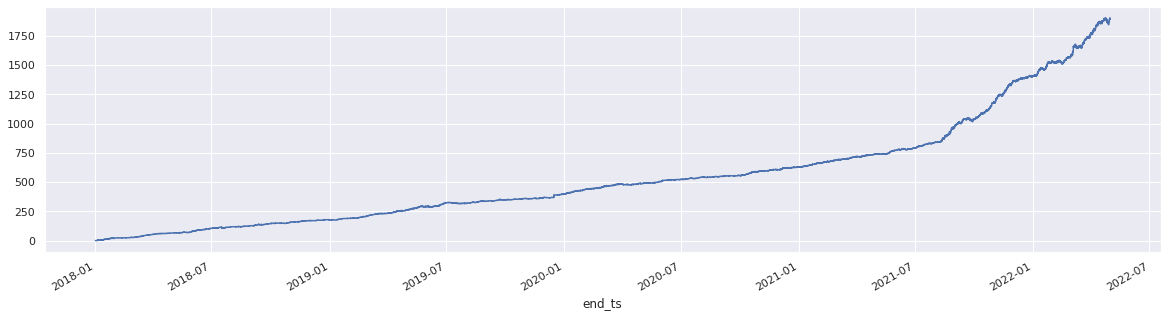

In [8]:
(
    predict_df[config["column_names"]["y"]]
    * predict_df[config["column_names"]["y_hat"]]
).sum(axis=1).cumsum().plot()

# Get data for analysis

In [9]:
metrics_df = preprocess_predictions_df(config, predict_df)
metrics_df.head()

INFO  removed rows with nans: 44027 / 887113 = 4.96%


volume          vwap  vwap.ret_0  vwap.ret_0.vol_adj  vwap.ret_0.vol_adj.c  vwap.ret_0.vol_adj.shift_-2  vwap.ret_0.vol_adj.shift_-2_hat  hit  trade_pnl
end_ts                    asset_id                                                                                                                                                         
2018-01-04 12:00:00-05:00 binance::ETH_USDT  677.267720    993.835677    0.001891            1.954649              1.812616             -0.393211                  0.075405   -1  -0.029650
                          binance::BTC_USDT  117.433287  14469.739034    0.003955            1.437304              1.378481              1.259730                  0.068264    1   0.085995
2018-01-04 12:05:00-05:00 binance::ETH_USDT  936.989460    993.949461    0.000114            0.078415              0.078405              0.110683                  0.087400    1   0.009674
                          binance::BTC_USDT   77.354675  14432.219854   -0.002596           -1.253307             -1.213842              0.535206                 -0.040640   -1  -0.021751
2018-01-04 12:10:00-05:00 binance::ETH_USDT  655.104630    993.344329   -0.000609           -0.393211             -0.391949              0.642775                  0.093588    1   0.060156

In [10]:
# Reset index to ease further preprocessing.
# TODO(Dan): Move index resetting under plotting funtions.
metrics_df_reset_index = metrics_df.reset_index()

# Stats

In [11]:
# Set oftenly used config parameters.
asset_id = config["column_names"]["asset_id"]
timestamp = config["column_names"]["timestamp"]
volume = config["column_names"]["volume"]
y = config["column_names"]["y"]
y_hat = config["column_names"]["y_hat"]
hit = config["column_names"]["hit"]
trade_pnl = config["column_names"]["trade_pnl"]
#
quantile_ranks = config["stats_kwargs"]["quantile_ranks"]
y_min_lim_hit_rate = config["plot_kwargs"]["y_min_lim_hit_rate"]
y_max_lim_hit_rate = config["plot_kwargs"]["y_max_lim_hit_rate"]
color = config["plot_kwargs"]["color"]
capsize = config["plot_kwargs"]["capsize"]
xticks_rotation = config["plot_kwargs"]["xticks_rotation"]

## By asset

### Hit rate

In [12]:
hit_by_asset = calculate_hit_rate_with_CI(metrics_df_reset_index, asset_id, hit)
plot_bars_with_widget(
    hit_by_asset, "hit_rate", y_min_lim_hit_rate, y_max_lim_hit_rate
)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### PnL

In [13]:
# Compute PnL for each asset id.
pnl_stats = (
    metrics_df.groupby(asset_id)[trade_pnl].sum().sort_values(ascending=False)
)
pnl_stats = pnl_stats.rename("y").to_frame()
# Confidence Intervals are currently excluded.
pnl_stats["errors"] = 0
# Plot PnL per asset id.
# TODO(Max): infer y-limits automatically.
plot_bars_with_widget(pnl_stats, "avg_pnl_by_asset", 0, 450)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

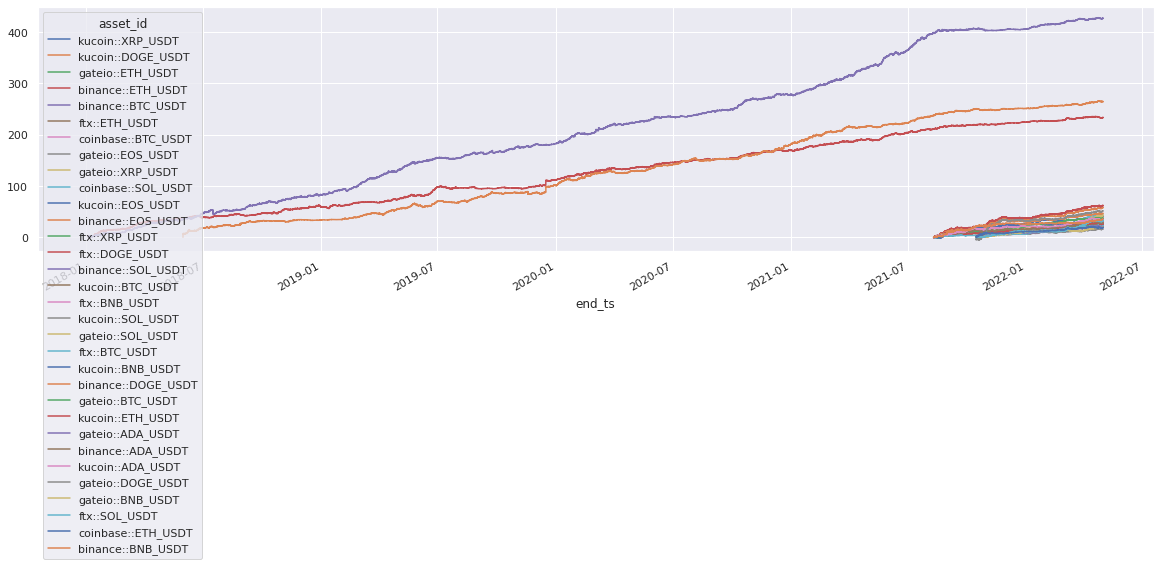

In [14]:
# Plot cumulative PnL over time per asset id.
_ = metrics_df[trade_pnl].dropna().unstack().cumsum().plot()

In [15]:
# Plot average trade PnL per asset id.
avg_pnl_by_asset = calculate_CI_for_PnLs_or_SR(
    metrics_df_reset_index, asset_id, trade_pnl
)
# TODO(Max): infer y-limits automatically.
plot_bars_with_widget(avg_pnl_by_asset, "avg_pnl_by_asset", 0, 0.005)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### Sharpe Ratio

In [16]:
# Compute bootstrapped Sharpe Ratio.
sr_by_asset = compute_sharpe_ratio(config, metrics_df_reset_index, asset_id)
# Add CIs and errors.
sr_ci_by_asset = calculate_CI_for_PnLs_or_SR(
    sr_by_asset, asset_id, "sharpe_ratio"
)
# Visualize results.
plot_bars_with_widget(sr_ci_by_asset, "sharpe_ratio", 0, 9)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

## By time

In [17]:
metrics_df_reset_index["hour"] = metrics_df_reset_index[timestamp].dt.hour
metrics_df_reset_index["weekday"] = metrics_df_reset_index[
    timestamp
].dt.day_name()
metrics_df_reset_index["month"] = metrics_df_reset_index[
    timestamp
].dt.month_name()

### Hit Rate

In [18]:
hits_by_time_hour = calculate_hit_rate_with_CI(
    metrics_df_reset_index, "hour", hit
)
plot_bars_with_widget(
    hits_by_time_hour, "avg_hit_rate", y_min_lim_hit_rate, y_max_lim_hit_rate
)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

In [19]:
hits_by_time_weekday = calculate_hit_rate_with_CI(
    metrics_df_reset_index, "weekday", hit
)
plot_bars_with_widget(
    hits_by_time_weekday, "avg_hit_rate", y_min_lim_hit_rate, y_max_lim_hit_rate
)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

In [20]:
hits_by_time_month = calculate_hit_rate_with_CI(
    metrics_df_reset_index, "month", hit
)
plot_bars_with_widget(
    hits_by_time_month, "avg_hit_rate", y_min_lim_hit_rate, y_max_lim_hit_rate
)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### PnL

In [21]:
pnl_by_time_hour = calculate_CI_for_PnLs_or_SR(
    metrics_df_reset_index, "hour", trade_pnl
)
# TODO(Max): infer y-limits automatically.
plot_bars_with_widget(pnl_by_time_hour, "avg_pnl", 0, 0.005)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

In [22]:
pnl_by_time_weekday = calculate_CI_for_PnLs_or_SR(
    metrics_df_reset_index, "weekday", trade_pnl
)
# TODO(Max): infer y-limits automatically.
plot_bars_with_widget(pnl_by_time_weekday, "avg_pnl", 0, 0.004)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

In [23]:
pnl_by_time_month = calculate_CI_for_PnLs_or_SR(
    metrics_df_reset_index, "month", trade_pnl
)
# TODO(Max): infer y-limits automatically.
plot_bars_with_widget(pnl_by_time_month, "avg_pnl", 0, 0.0055)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### Sharpe Ratio

In [24]:
# Compute bootstrapped Sharpe Ratio.
sr_by_hour = compute_sharpe_ratio(config, metrics_df_reset_index, "hour")
# Add CIs and errors.
sr_ci_by_hour = calculate_CI_for_PnLs_or_SR(sr_by_hour, "hour", "sharpe_ratio")
# Visualize results.
plot_bars_with_widget(sr_ci_by_hour, "sharpe_ratio", 0, 9)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

In [25]:
# Compute bootstrapped Sharpe Ratio.
sr_by_weekday = compute_sharpe_ratio(config, metrics_df_reset_index, "weekday")
# Add CIs and errors.
sr_ci_by_weekday = calculate_CI_for_PnLs_or_SR(
    sr_by_weekday, "weekday", "sharpe_ratio"
)
# Visualize results.
plot_bars_with_widget(sr_ci_by_weekday, "sharpe_ratio", 0, 7)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

In [26]:
# Compute bootstrapped Sharpe Ratio.
sr_by_month = compute_sharpe_ratio(config, metrics_df_reset_index, "month")
# Add CIs and errors.
sr_ci_by_month = calculate_CI_for_PnLs_or_SR(sr_by_month, "month", "sharpe_ratio")
# Visualize results.
plot_bars_with_widget(sr_ci_by_month, "sharpe_ratio", 0, 9)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

## By prediction magnitude

In [27]:
prediction_magnitude = ".".join([y_hat, "quantile_rank"])
metrics_df_reset_index[prediction_magnitude] = pd.qcut(
    metrics_df_reset_index[y_hat], quantile_ranks, labels=False
)

### Hit rate

In [28]:
hits_by_prediction_magnitude = calculate_hit_rate_with_CI(
    metrics_df_reset_index, prediction_magnitude, hit
)
plot_bars_with_widget(
    hits_by_prediction_magnitude,
    "avg_hit_rate",
    y_min_lim_hit_rate,
    y_max_lim_hit_rate,
)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### PnL

In [29]:
pnl_by_prediction_magnitude = calculate_CI_for_PnLs_or_SR(
    metrics_df_reset_index, prediction_magnitude, trade_pnl
)
# TODO(Max): infer y-limits automatically.
plot_bars_with_widget(pnl_by_prediction_magnitude, "avg_pnl", 0, 0.01)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### Sharpe Ratio

In [30]:
# Compute bootstrapped Sharpe Ratio.
sr_by_prediction_magnitude = compute_sharpe_ratio(
    config, metrics_df_reset_index, prediction_magnitude
)
# Add CIs and errors.
sr_ci_by_prediction_magnitude = calculate_CI_for_PnLs_or_SR(
    sr_by_prediction_magnitude, prediction_magnitude, "sharpe_ratio"
)
# Visualize results.
plot_bars_with_widget(sr_ci_by_prediction_magnitude, "sharpe_ratio", -1, 12)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

## By volume

In [31]:
volume_quantile = ".".join([volume, "quantile_rank"])
metrics_df_reset_index[volume_quantile] = metrics_df_reset_index.groupby(
    asset_id
)[volume].transform(lambda x: pd.qcut(x, quantile_ranks, labels=False))

### Hit rate

In [32]:
hits_by_volume = calculate_hit_rate_with_CI(
    metrics_df_reset_index, volume_quantile, hit
)
plot_bars_with_widget(
    hits_by_volume, "avg_hit_rate", y_min_lim_hit_rate, y_max_lim_hit_rate
)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### PnL

In [33]:
pnl_by_volume = calculate_CI_for_PnLs_or_SR(
    metrics_df_reset_index, volume_quantile, trade_pnl
)
# TODO(Max): infer y-limits automatically.
plot_bars_with_widget(pnl_by_volume, "avg_pnl", 0.0005, 0.0045)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦

### Sharpe Ratio

In [34]:
# Compute bootstrapped Sharpe Ratio.
sr_by_volume_quantile = compute_sharpe_ratio(
    config, metrics_df_reset_index, volume_quantile
)
# Add CIs and errors.
sr_ci_by_volume_quantile = calculate_CI_for_PnLs_or_SR(
    sr_by_volume_quantile, volume_quantile, "sharpe_ratio"
)
# Visualize results.
plot_bars_with_widget(sr_ci_by_volume_quantile, "sharpe_ratio", 0, 9)

interactive(children=(ToggleButtons(description='Sort by:', options=('x', 'y', 'ci_low', 'ci_high', False), vaÃÂÃÂ¢ÃÂÃÂÃÂÃÂ¦